In [1]:
import h5py
import numpy as np

from sourcesep.sim import SimData
from sourcesep.utils.config import load_config

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'


paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] / 'sims' / '2023-03-08.h5', 'r')
for key in f.keys():
    print(key, f[key].shape)

Paths are for dataset tagged: all
A (216000, 3)
B (5, 60)
E (5, 60)
H_dox (216000,)
H_ox (216000,)
L_arr (60,)
M (216000,)
Mu_dox (60,)
Mu_ox (60,)
N (216000, 5)
O (216000, 5, 60)
S (3, 60)
T_arr (216000,)
W (3, 5)


In [2]:
# prepare data and ground truth
O = f['O'][:]
A = f['A'][:]
L_arr = f['L_arr'][:]

# flatten channels
O = O.reshape(O.shape[0],-1)
print(O.shape)

(216000, 300)


In [3]:
# Ignoring hemodynamics, we can construct the mixing matrix as:
Wij  = f['W'][:]
Sil = f['S'][:]

Mjl = np.einsum('ij,il->ijl', Wij, Sil)
Mjl = Mjl.reshape(3, -1)
M = Mjl.T.copy()

In [4]:
M.shape

(300, 3)

In [5]:
from sklearn.decomposition import NMF

model = NMF(n_components=3, init=None,
            solver='cd', beta_loss='frobenius',
            tol=0.0001, max_iter=1000, random_state=None,
            alpha_W=0.1, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)
W = model.fit_transform(O.T)
H = model.components_

/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [6]:
# print shapes along with name of the variable
print('W', W.shape)
print('H', H.shape)
print('A', A.shape)

W (300, 3)
H (3, 216000)
A (216000, 3)


In [7]:
def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x)/mean_x

def standardize(x):
    mean_x = np.mean(x)
    std_x = np.std(x)
    return (x - mean_x)/std_x

shapes: (216000, 3) (216000, 3)
correlation: 0.59


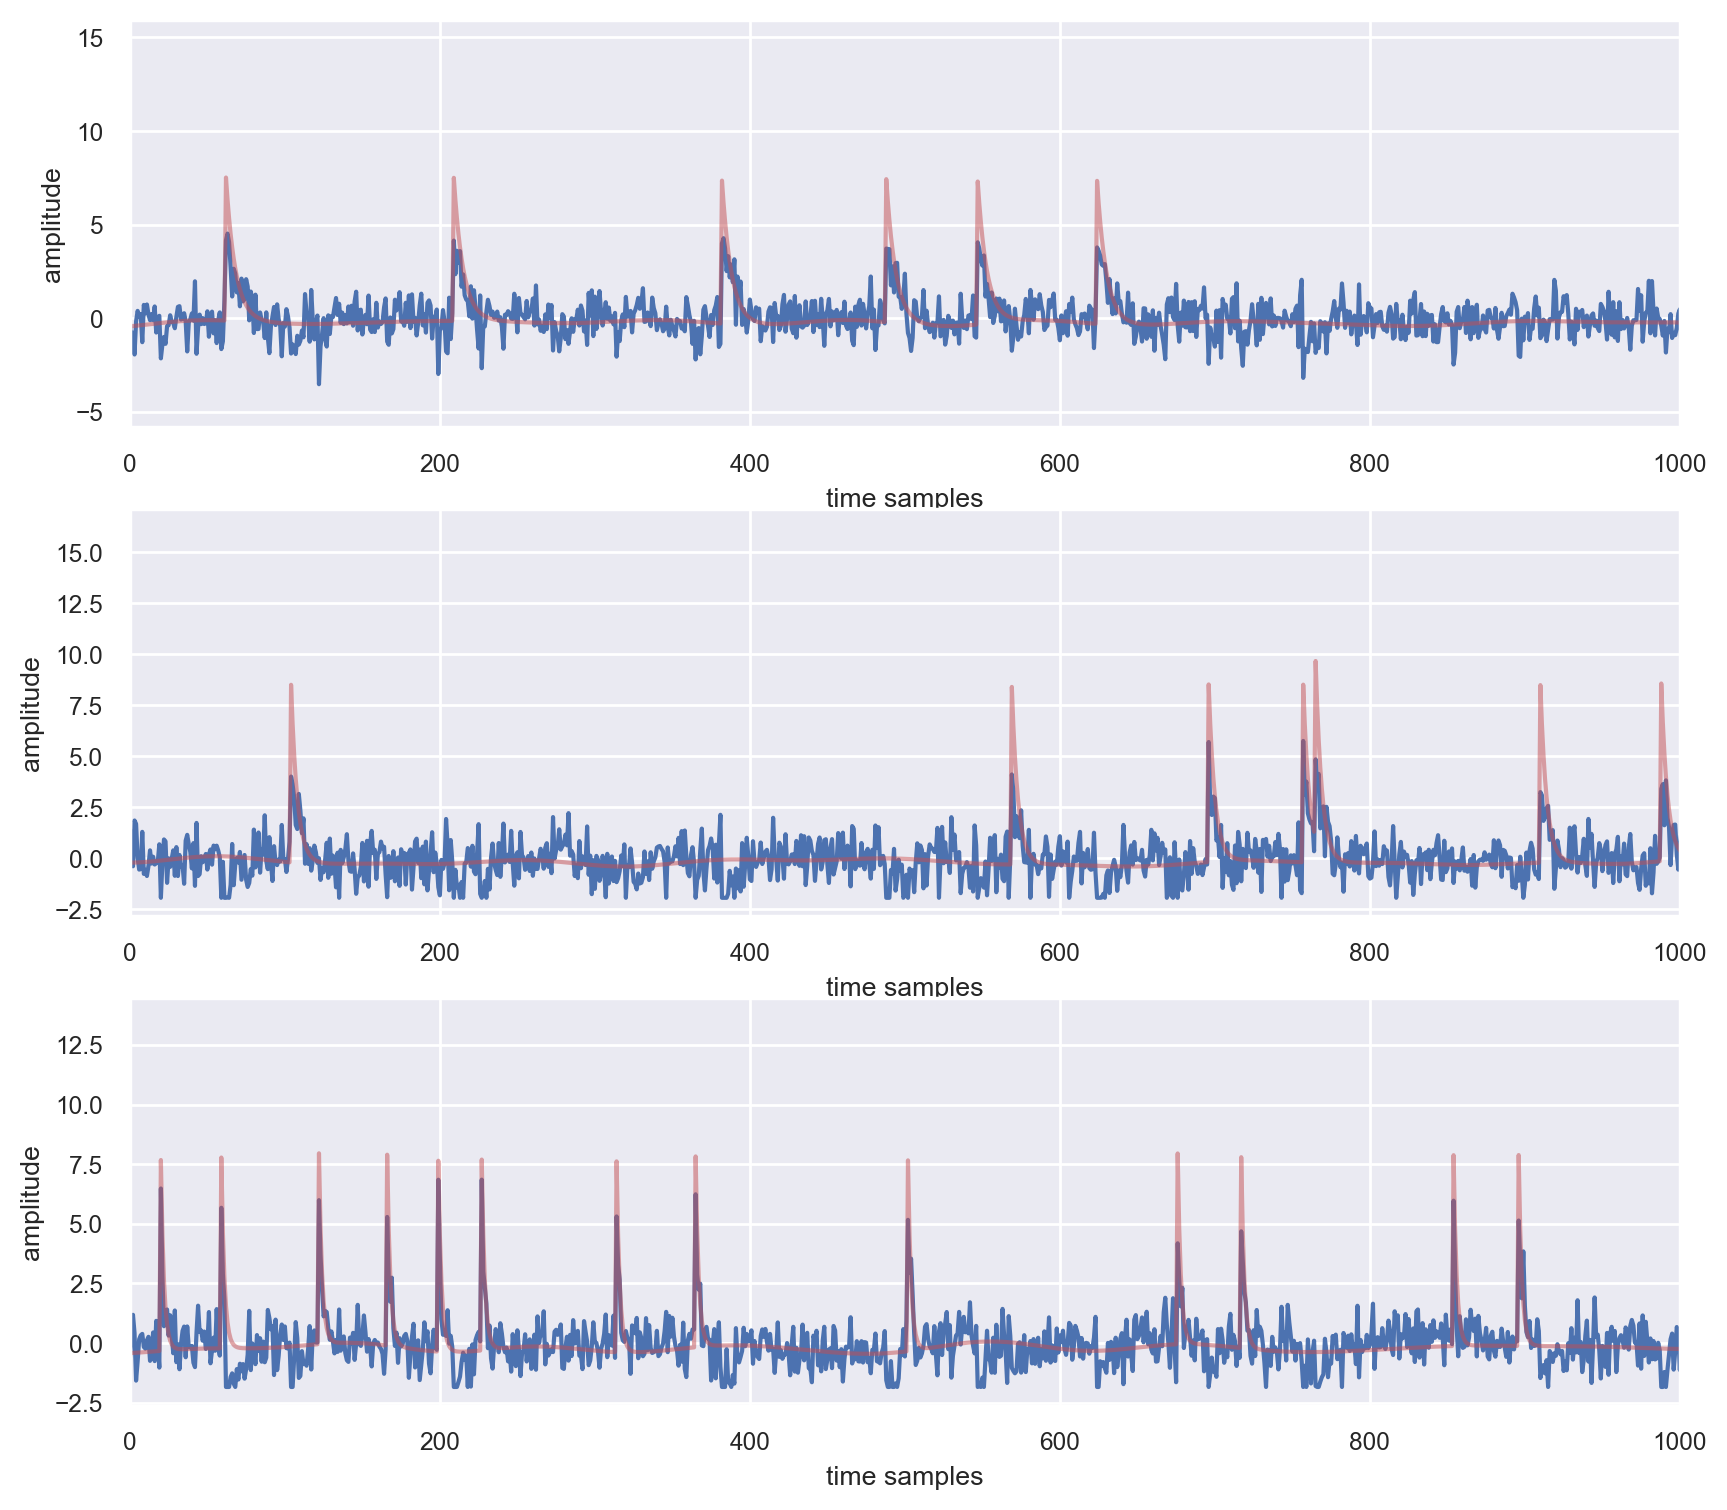

In [8]:
from sourcesep.utils.compute import perm_avgabscorr

print('shapes:', H.T.shape, A.shape)
perm, corr = perm_avgabscorr(H.T, A)
best_perm = perm[np.argmax(corr)]
print(f'correlation: {np.max(corr):.2f}')

# plot the first 3 components
fig, ax = plt.subplots(3,1, figsize=(10,9))
for i in range(3):
    ax[i].plot(standardize(H[best_perm[i],:]),'b')
    ax[i].plot(standardize(A[:,i]),alpha = 0.5,c='r')
    ax[i].set(xlabel='time samples', ylabel='amplitude', xlim=(0, 1000))
plt.show()

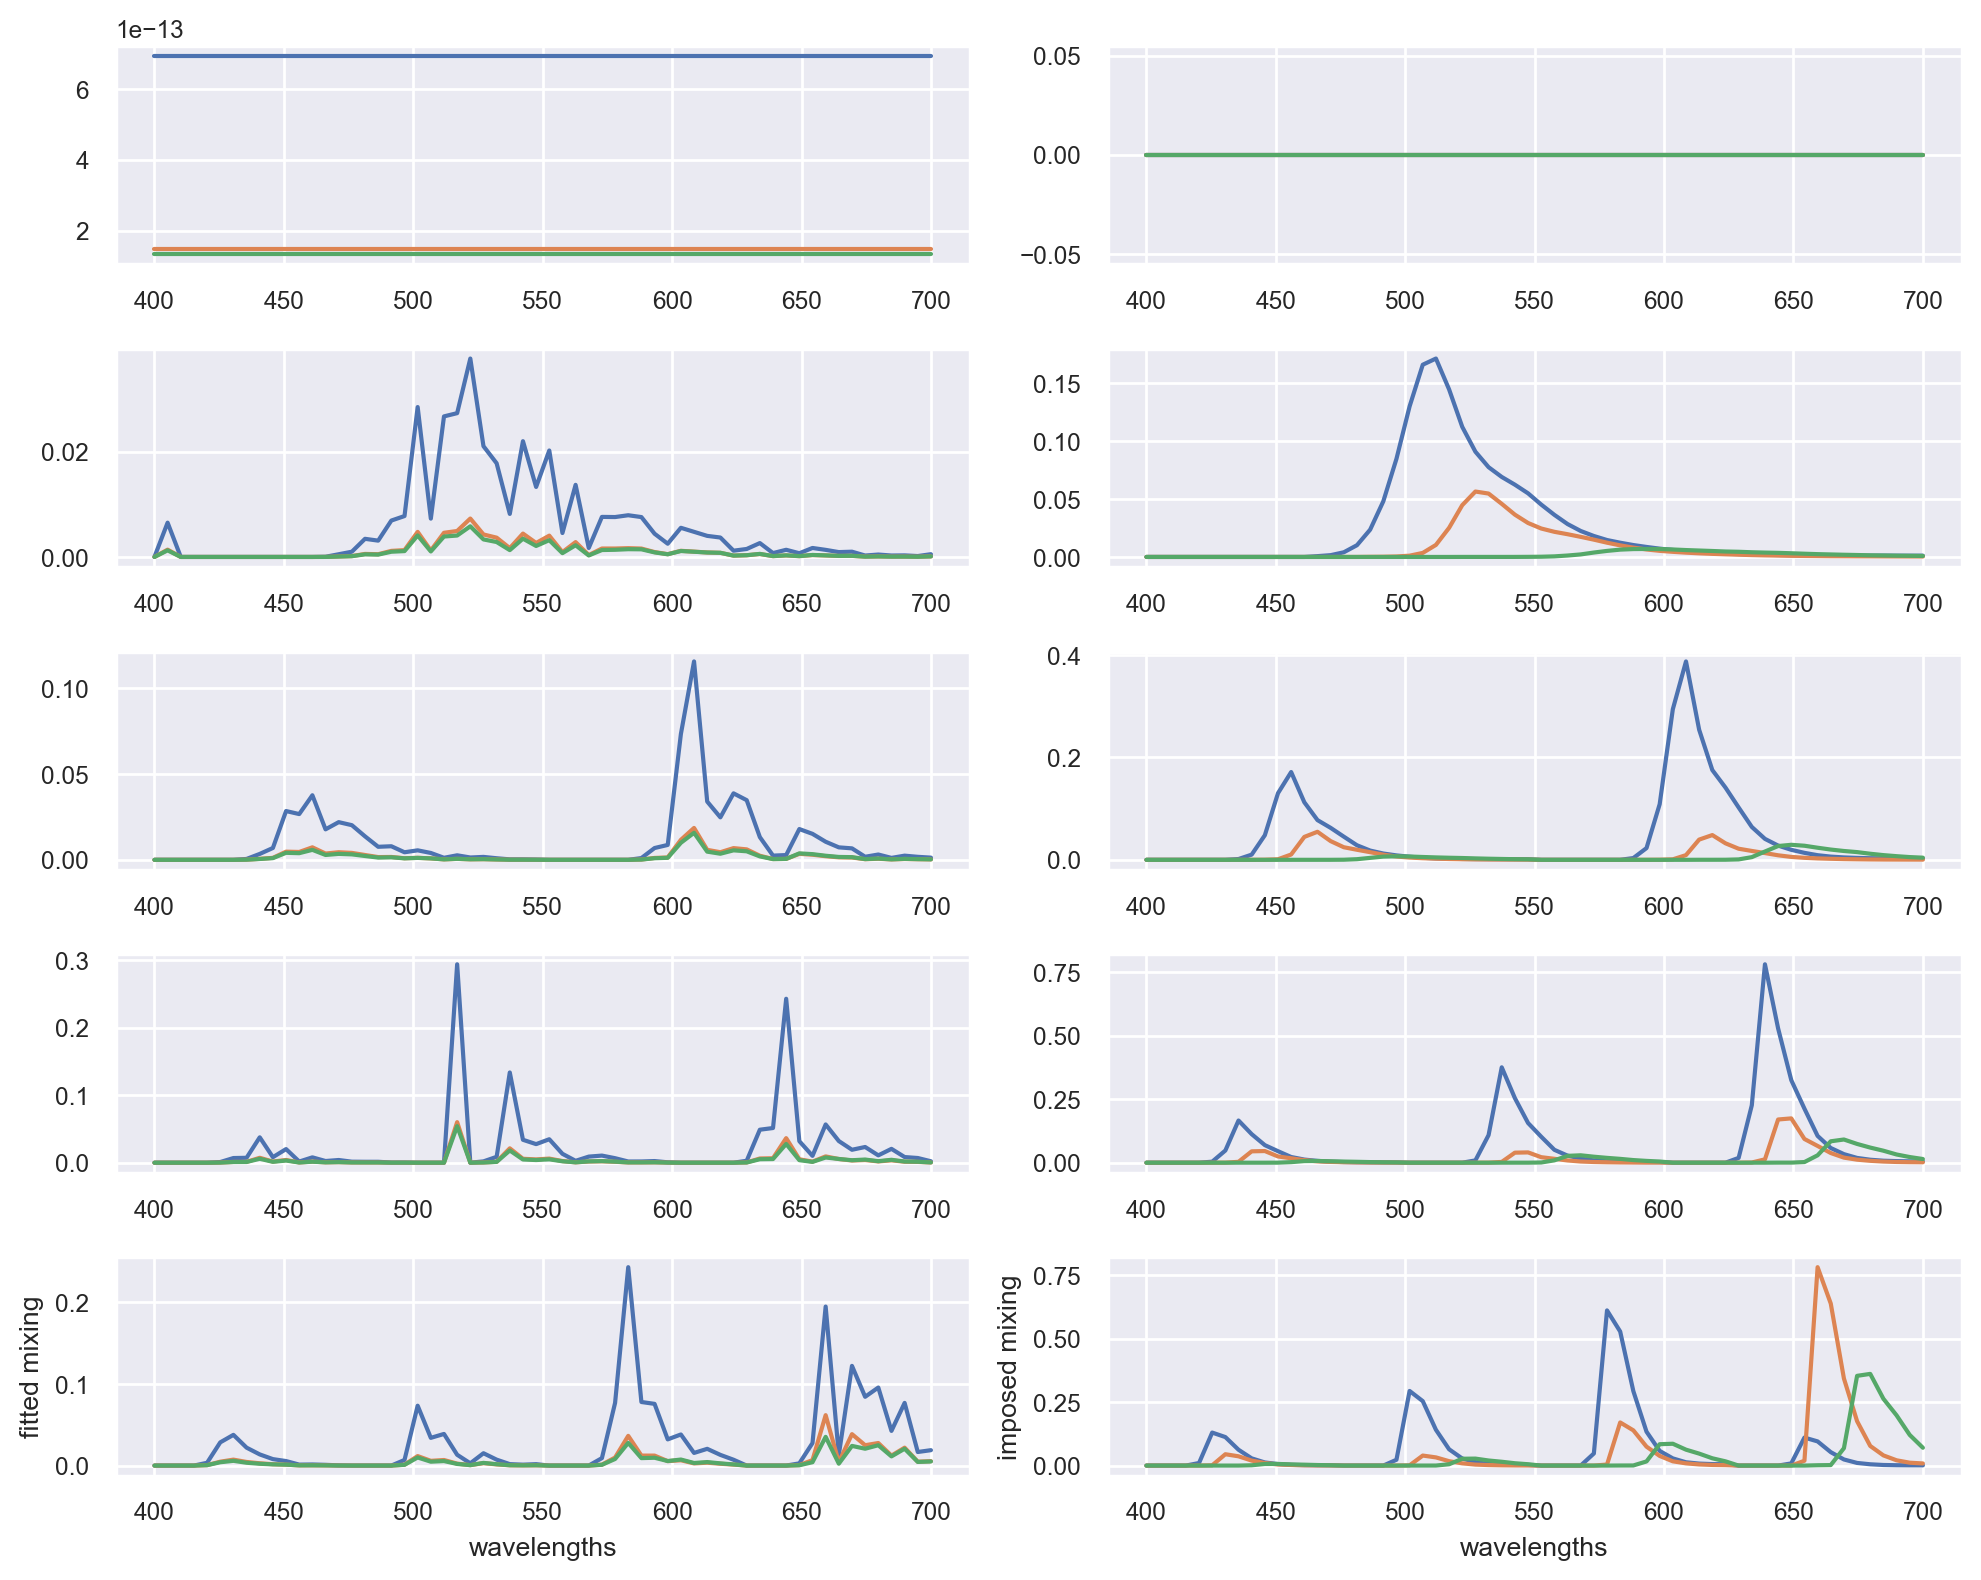

In [9]:
n_factors = 3
n_lasers = 5
fig, ax = plt.subplots(5,2, figsize=(10,8))
W_norm = W / (np.sum(W,axis=1, keepdims=True) + 1e-10)

for laser in range(n_lasers):
    idx = np.arange(L_arr.size)*laser
    for factor in range(n_factors):
        ax[laser,0].plot(L_arr, W[idx,factor])

for laser in range(n_lasers):
    idx = np.arange(L_arr.size)*laser
    for factor in range(n_factors):
        ax[laser,1].plot(L_arr, M[idx,factor])

ax[n_lasers-1,0].set(xlabel='wavelengths', ylabel='fitted mixing')
ax[n_lasers-1,1].set(xlabel='wavelengths', ylabel='imposed mixing')
plt.tight_layout()

In [10]:
from sklearn.decomposition import NMF

# attempt a fit with initial values for W
W_init = M.copy()
H_init = np.random.rand(W_init.shape[1],O.T.shape[1])

model = NMF(n_components=3, init='custom',
            solver='cd', beta_loss='frobenius',
            tol=0.0001, max_iter=1000, random_state=None,
            alpha_W=0.1, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)
W = model.fit_transform(O.T, W=W_init, H=H_init)
H = model.components_

/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


shapes: (216000, 3) (216000, 3)
correlation: 0.59


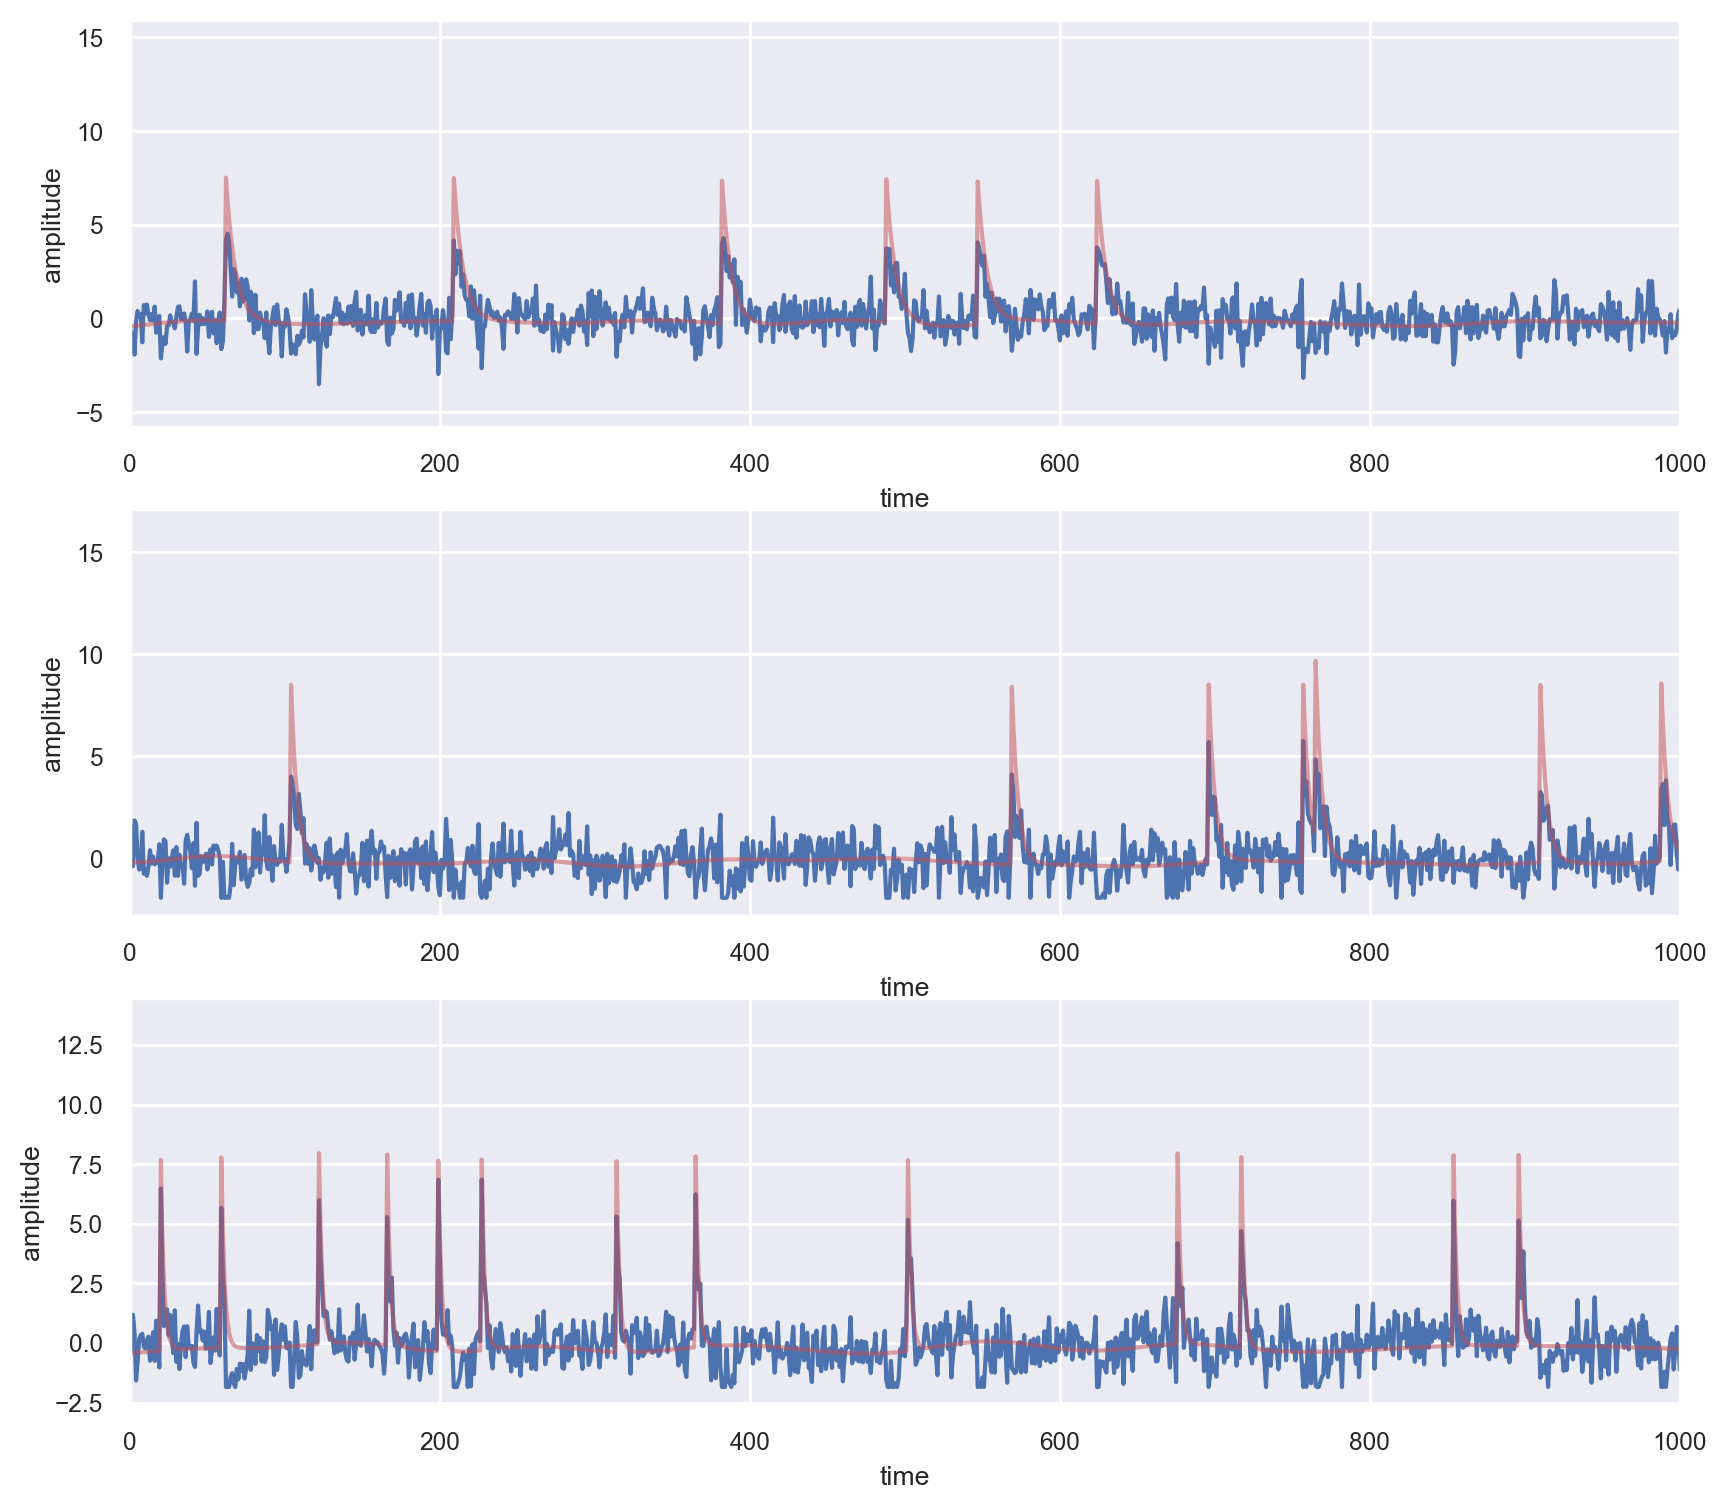

In [11]:
from sourcesep.utils.compute import perm_avgabscorr

print('shapes:', H.T.shape, A.shape)
perm, corr = perm_avgabscorr(H.T, A)
best_perm = perm[np.argmax(corr)]
print(f'correlation: {np.max(corr):.2f}')

# plot the first 3 components
fig, ax = plt.subplots(3,1, figsize=(10,9))
for i in range(3):
    ax[i].plot(standardize(H[best_perm[i],:]),'b')
    ax[i].plot(standardize(A[:,i]),alpha = 0.5,c='r')
    ax[i].set(xlabel='time', ylabel='amplitude', xlim=(0, 1000))
plt.show()

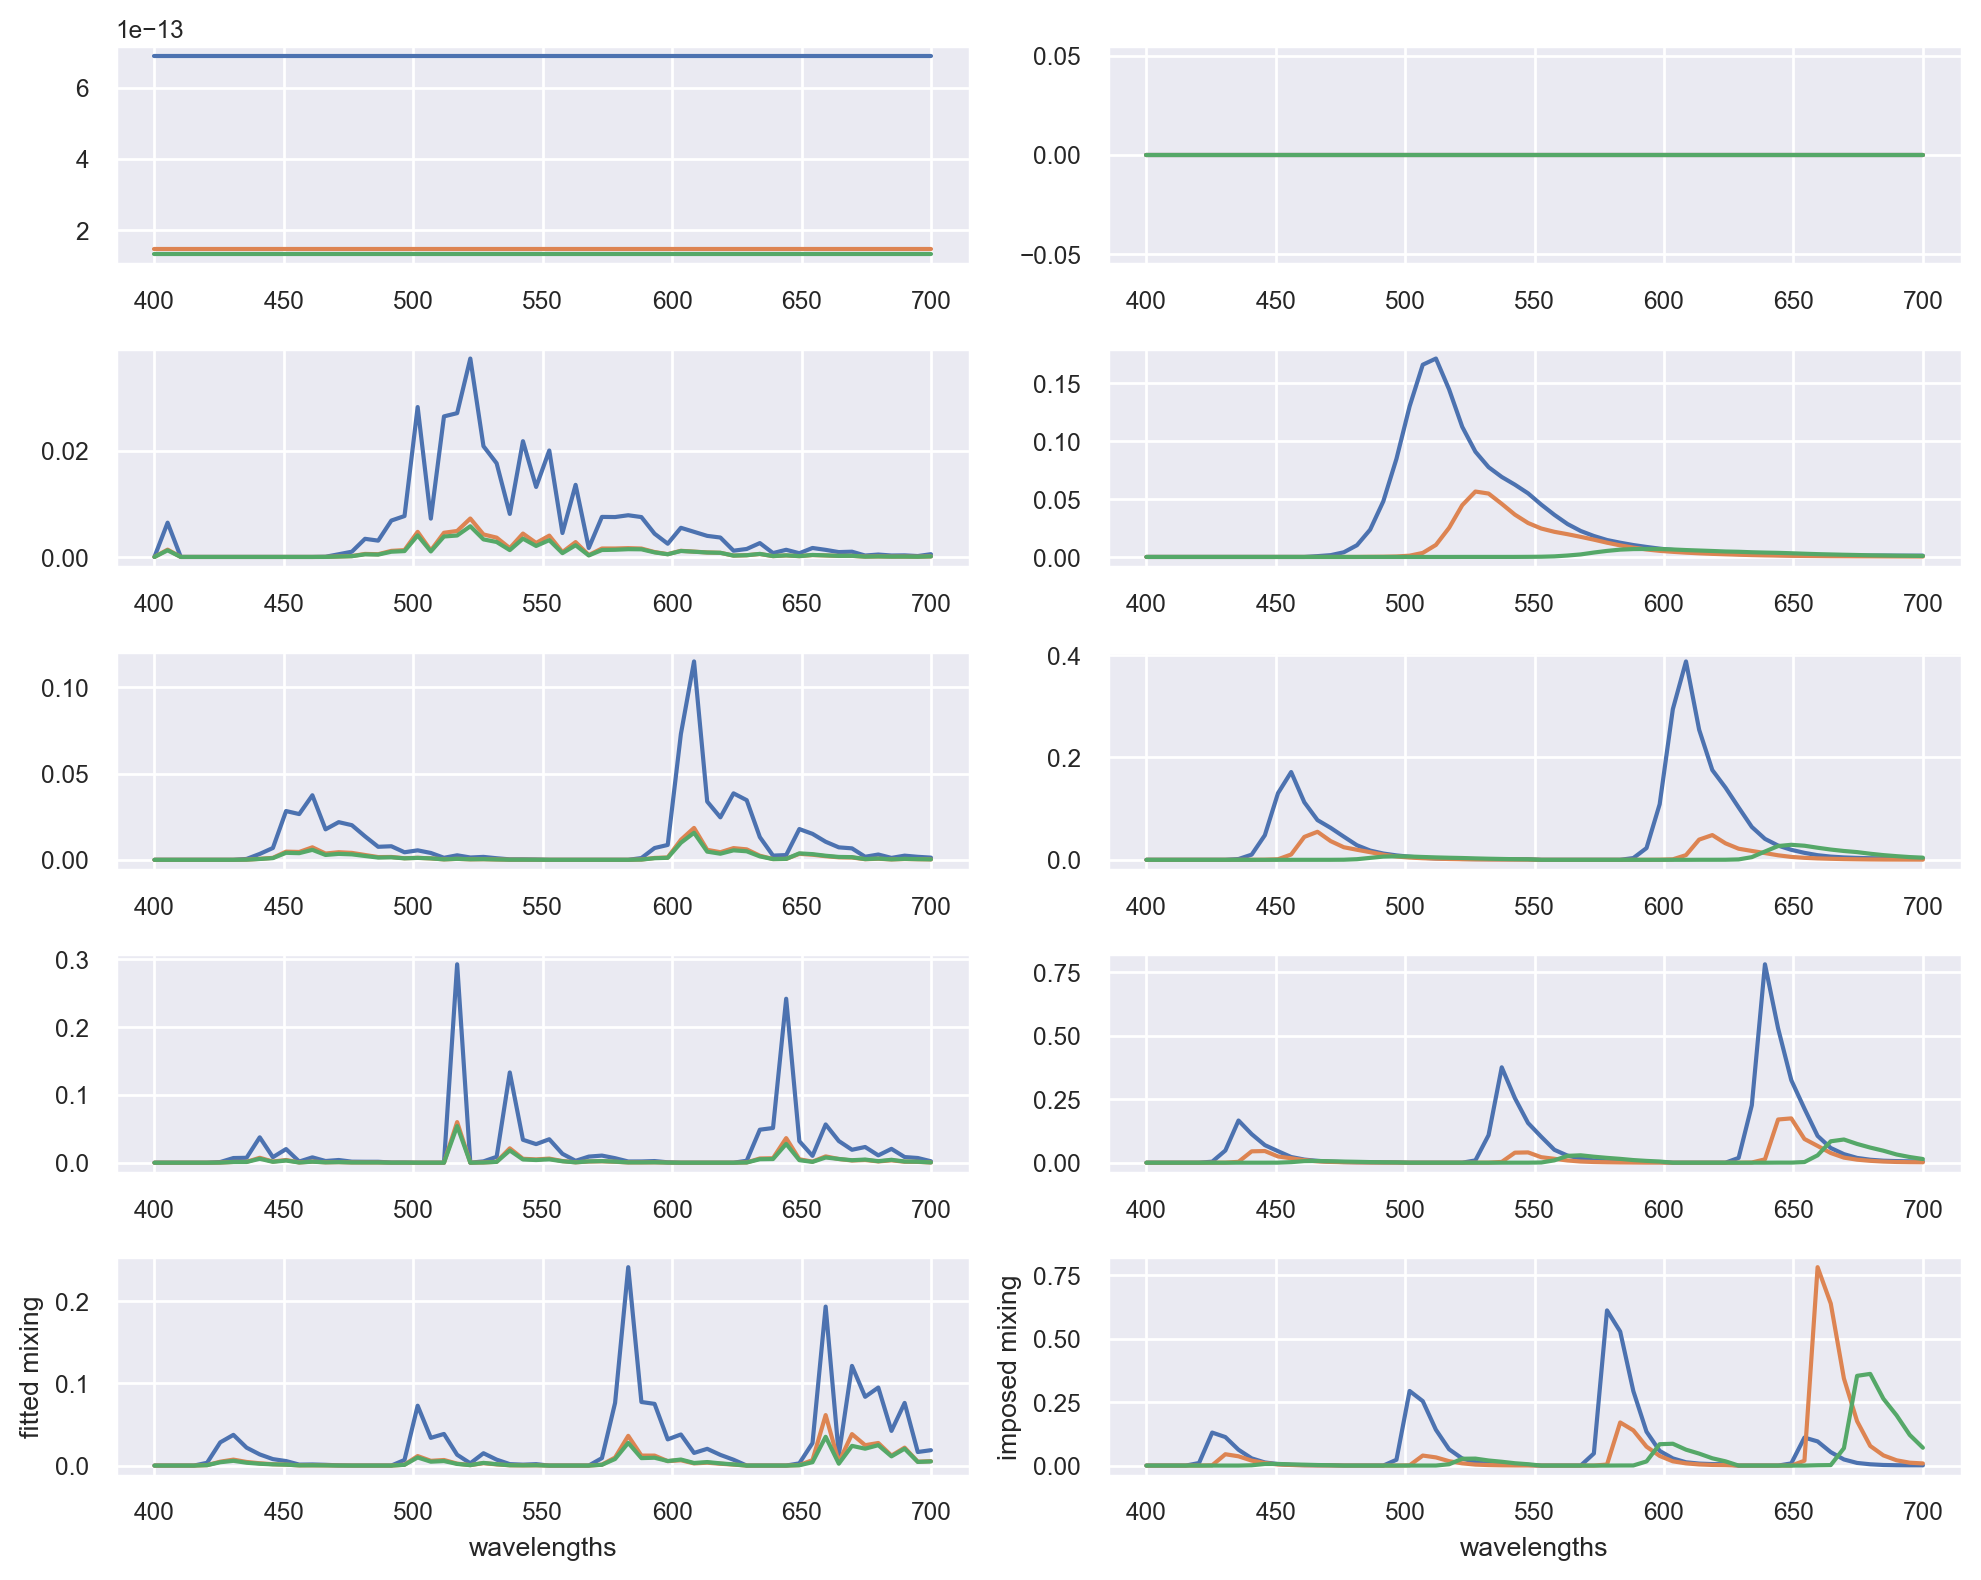

In [12]:
n_factors = 3
n_lasers = 5
fig, ax = plt.subplots(5,2, figsize=(10,8))
W_norm = W / (np.sum(W,axis=1, keepdims=True) + 1e-10)

for laser in range(n_lasers):
    idx = np.arange(L_arr.size)*laser
    for factor in range(n_factors):
        ax[laser,0].plot(L_arr, W[idx,factor])

for laser in range(n_lasers):
    idx = np.arange(L_arr.size)*laser
    for factor in range(n_factors):
        ax[laser,1].plot(L_arr, M[idx,factor])

ax[n_lasers-1,0].set(xlabel='wavelengths', ylabel='fitted mixing')
ax[n_lasers-1,1].set(xlabel='wavelengths', ylabel='imposed mixing')
plt.tight_layout()

/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,value,params_alpha_H,params_alpha_W,params_l1_ratio,value_cat
1075,0.51364,0.01975,0.436607,0.000458,"(0.462, 0.514]"


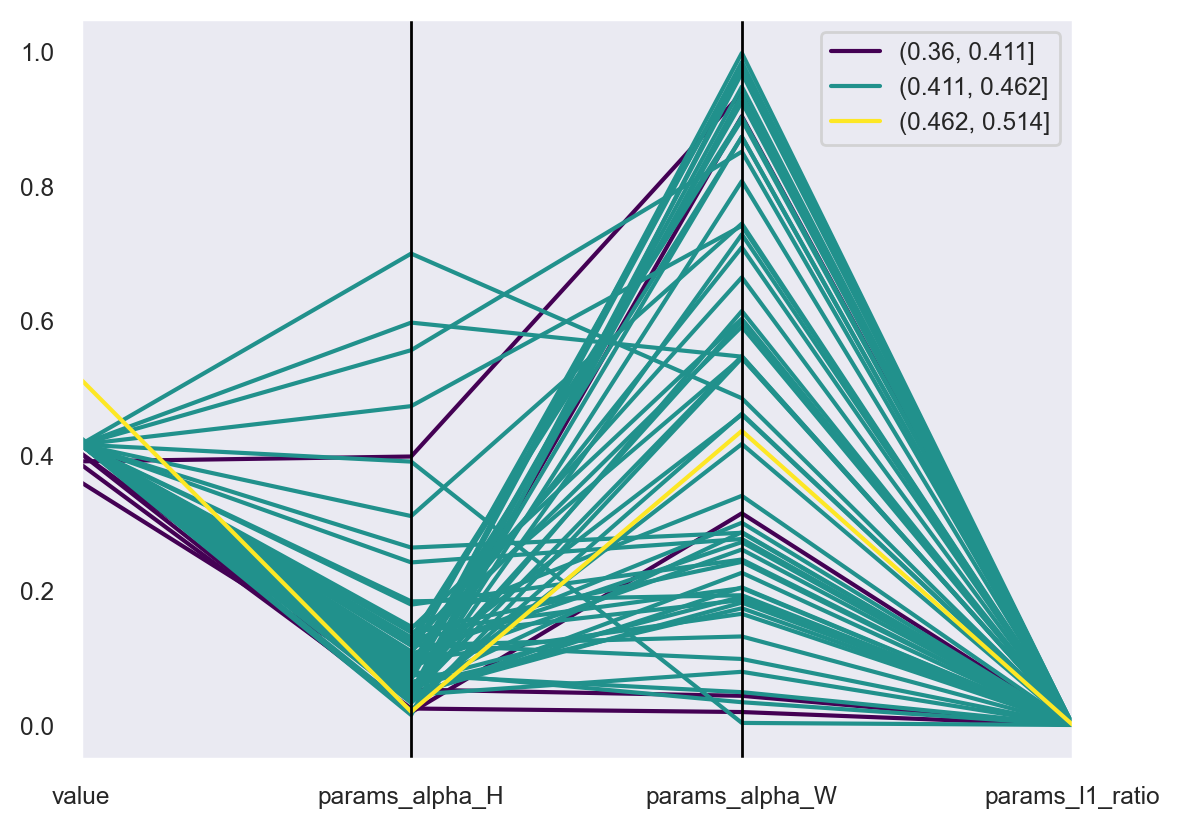

In [13]:
# summarize results of hyperparameter optimization study
import pandas as pd
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

study = optuna.load_study(study_name='nmf-optimization', storage='sqlite:///../sourcesep/models/nmf-optimization.db')
#convert results in study to a dataframe
df = study.trials_dataframe()
df = df[['value', 'params_alpha_H', 'params_alpha_W', 'params_l1_ratio']]

# sort df by 'value' column
df = df.sort_values(by='value', ascending=True)
# bin the values of the 'value' column
df['value_cat'] = pd.cut(df['value'], bins=10).astype(str)
# filter values of 'value' to only those above 0.3
df = df[df['value'] > 0.3]

pd.plotting.parallel_coordinates(df[['value', 
                                     'params_alpha_H', 
                                     'params_alpha_W', 
                                     'params_l1_ratio', 
                                     'value_cat']], 
                                     class_column='value_cat', 
                                     colormap='viridis')

#print the row with the maximum value
df[df['value'] == df['value'].max()]